# SWOT L2 virtualizarr example
### (NASA CMR Shortname: SWOT_L2_LR_SSH_Basic_2.0)

#### *Author: Ed Armstrong, PO.DAAC*

*Reference herein to any specific commercial product, process, or service by trade name, trademark, manufacturer, or otherwise, does not constitute or imply its endorsement by the United States Government or the Jet Propulsion Laboratory, California Institute of Technology.*

In [1]:
# Built-in packages
import os
import sys

# Filesystem management 
import fsspec
import earthaccess

# Data handling
import xarray as xr
from virtualizarr import open_virtual_dataset

# Parallel computing 
import multiprocessing
from dask import delayed
import dask.array as da
from dask.distributed import Client

# Pandas
import pandas as pd

# Numpy
import numpy as np

# Other mapping
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
 pip list | grep -E  -e  '(xarray|virtualizarr|earthaccess|kerchunk)'

if: Expression Syntax.
then: Command not found.
cf_xarray                 0.10.7
earthaccess               0.14.0
kerchunk                  0.2.7
virtualizarr              1.3.2
xarray                    2025.1.1
Note: you may need to restart the kernel to use updated packages.


## 1. Get Data File S3 endpoints in Earthdata Cloud 
The first step is to find the S3 endpoints to the files. Handling access credentials to Earthdata and then finding the endpoints can be done a number of ways (e.g. using the `requests`, `s3fs` packages) but we use the `earthaccess` package for its ease of use. We get the endpoints for all files in the CCMP record.

In [3]:
# Get Earthdata creds
earthaccess.login()

In [4]:
# Get AWS creds. Note that if you spend more than 1 hour in the notebook, you may have to re-run this line!!!
fs = earthaccess.get_fsspec_https_session()

In [5]:
# Locate a subset of SWOT L2 file information / metadata:
granule_info = earthaccess.search_data(
    short_name="SWOT_L2_LR_SSH_Basic_2.0",
    temporal=("2024-01-01", "2024-03-30"),
    )

In [6]:
# Get S3 or HTTPS endpoints for all files:
data_s3links = [g.data_links(access="https")[0] for g in granule_info]
print(len(data_s3links))

3408


## 2. Generate and open reference files 

In [7]:
# This will be assigned to 'loadable_variables' and needs to be modified per the specific 
# coord names of the data set:
coord_vars = ["num_lines","num_pixels"]
reader_opts = {"storage_options": fs.storage_options} # S3 filesystem creds from previous section.


The reference can be saved to file and used to open the corresponding CCMP data file with Xarray:

In [8]:
# Open data using the reference file, using a small wrapper function around xarray's open_dataset. 
# This will shorten code blocks in other sections. 
def get_vds_mapper(vds_link, in_cloud_region=False):
    """
    Produces a virtudal dataset mapper that can be passed to xarray. 
    
    * vds_link: str, link to the mapper
    * in_cloud_region: bool, True if in cloud in the same region as the data, 
        False otherwise.
    """

    if in_cloud_region:
        fs_data = earthaccess.get_s3_filesystem(daac="PODAAC")
        remote_protocol = "s3"
    else:
        fs_data = earthaccess.get_fsspec_https_session()
        # We set this header to identify usage of the VDS. This helps us support continued development. 
        fs_data.client_kwargs['headers']['User-Agent'] = "virtual-dataset-consumer"
        remote_protocol = "https"
    
    storage_opts = {"fo": vds_link, "remote_protocol": remote_protocol, "remote_options": fs_data.storage_options}
    fs_ref = fsspec.filesystem('reference', **storage_opts)
    return fs_ref.get_mapper('')

### 2.2.1 Process some files using Dask local cluster in parallel
If using an `m6i.4xlarge` AWS EC2 instance, there are 16 CPUs available and each should have enough memory to utilize all at once. If working on a different VM-type, change the `n_workers` in the call to `Client()` below as needed.

In [9]:
# Check how many cpu's are on this VM:
print("CPU count =", multiprocessing.cpu_count())

CPU count = 16


In [10]:
# Start up cluster and print some information about it:
client = Client(n_workers=8, threads_per_worker=4)
print(client.cluster)
print("View any work being done on the cluster here", client.dashboard_link)

LocalCluster(da25bb6e, 'tcp://127.0.0.1:55721', workers=8, threads=32, memory=64.00 GiB)
View any work being done on the cluster here http://127.0.0.1:8787/status


In [13]:
%%time
# Create individual references in memory:
open_vds_par = delayed(open_virtual_dataset)
tasks = [
    open_vds_par(p, indexes={}, reader_options=reader_opts, loadable_variables=coord_vars) 
    for p in data_s3links[:30] # First 30 passes
    ]
virtual_ds_list = list(da.compute(*tasks)) # The xr.combine_nested() function below needs a list rather than a tuple.
print(len((virtual_ds_list)))

30
CPU times: user 7.73 s, sys: 3.61 s, total: 11.3 s
Wall time: 1min 43s


In [14]:
%%time

# Create the combined reference. Extract out a start time for each file (pass). Just do a few files.
orbit_start = []
for g in granule_info[:len(data_s3links[0:30])]:
    datetime_str = g['umm']['TemporalExtent']['RangeDateTime']['BeginningDateTime']
    datetime_obj = np.datetime64(datetime_str)
    orbit_start.append(datetime_obj)

# create panda list for better management and naming
orbit_start = pd.Index(orbit_start, name="orbit")

coords_list = ['latitude', 'longitude' ]
virtual_ds_combined = xr.concat(virtual_ds_list, orbit_start, coords=coords_list, compat='override', combine_attrs='drop_conflicts')

CPU times: user 186 ms, sys: 9.52 ms, total: 195 ms
Wall time: 194 ms


<timed exec>:5: UserWarning: no explicit representation of timezones available for np.datetime64


In [15]:
# Save in JSON and PARQUET format:
fname_combined_json = 'ref_combined_swotl2.json'
fname_combined_parq = 'ref_combined_swotl2.parq'
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_json, format='json')
virtual_ds_combined.virtualize.to_kerchunk(fname_combined_parq, format='parquet')

In [16]:
%%time

# Lets open the JSON VDS
vds_link = fname_combined_json
vds_mapper = get_vds_mapper(vds_link, in_cloud_region=False)

## No modification needed!
data = xr.open_dataset(
    vds_mapper, engine="zarr", chunks={},
    backend_kwargs={"consolidated": False}
)
data


CPU times: user 500 ms, sys: 219 ms, total: 719 ms
Wall time: 4.77 s


<xarray.Dataset> Size: 3GB
Dimensions:                                (orbit: 30, num_lines: 9866,
                                            num_pixels: 69, num_sides: 2)
Coordinates:
    latitude                               (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    longitude                              (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
  * orbit                                  (orbit) datetime64[ns] 240B 2023-1...
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/24)
    ancillary_surface_classification_flag  (orbit, num_lines, num_pixels) float32 82MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    distance_to_coast                      (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    dynamic_ice_flag                       (orbit, num_lines, num_pixels) float32 82MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    geoid                                  (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    heading_to_coast                       (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    height_cor_xover                       (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    ...                                     ...
    ssha_karin                             (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    ssha_karin_2                           (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    ssha_karin_2_qual                      (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    ssha_karin_qual                        (orbit, num_lines, num_pixels) float64 163MB dask.array<chunksize=(1, 9866, 69), meta=np.ndarray>
    time                                   (orbit, num_lines) datetime64[ns] 2MB dask.array<chunksize=(1, 9866), meta=np.ndarray>
    time_tai                               (orbit, num_lines) datetime64[ns] 2MB dask.array<chunksize=(1, 9866), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                      CF-1.7
    title:                            Level 2 Low Rate Sea Surface Height Dat...
    source:                           Ka-band radar interferometer
    platform:                         SWOT
    reference_document:               D-56407_SWOT_Product_Description_L2_LR_SSH
    contact:                          podaac@jpl.nasa.gov
    ...                               ...
    xref_param_l2_lr_precalssh_file:  SWOT_Param_L2_LR_PreCalSSH_20000101T000...
    xref_reforbittrack_files:         SWOT_RefOrbitTrack125mPass1_Nom_2000010...
    xref_geco_database_version:       v102
    ellipsoid_semi_major_axis:        6378137.0
    ellipsoid_flattening:             0.0033528106647474805
    references:                       V1.2.1

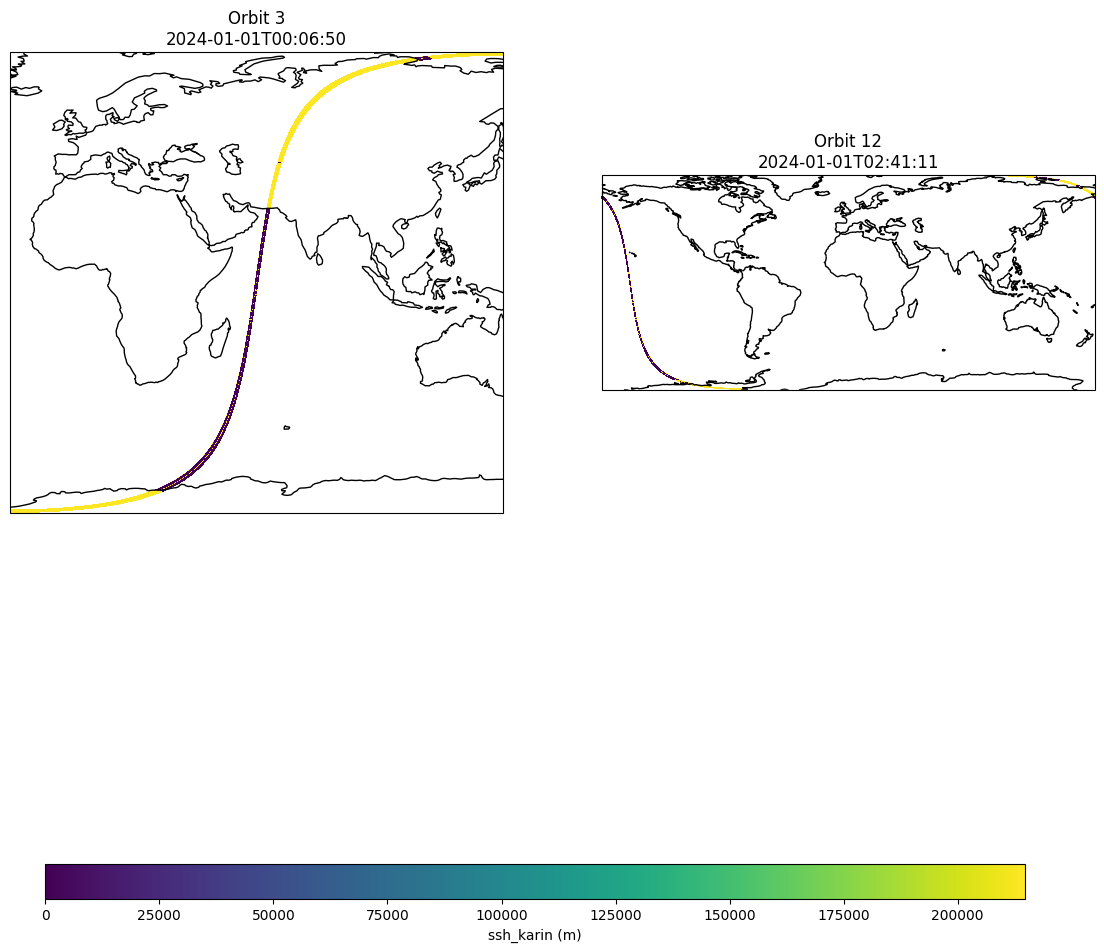

In [17]:
# Make some simple plots over a few orbits to visualize the data

#orbits = [0, 1, 2, 3, 12, 15]
orbits = [3,12]


fig, axes = plt.subplots(
    1, 2, figsize=(14, 14),
    subplot_kw={"projection": ccrs.PlateCarree()}
)
axes = axes.ravel()

for ax, k in zip(axes, orbits):

    ssh = data.ssh_karin.isel(orbit=k).load()
    lat = data.latitude.isel(orbit=k).load()
    lon = data.longitude.isel(orbit=k).load()

    # light decimation (huge speedup, no visual loss)
    ssh = ssh[:, ::3]
    lat = lat[:, ::3]
    lon = lon[:, ::3]

    pcm = ax.pcolormesh(
        lon,
        lat,
        ssh,
        transform=ccrs.PlateCarree(),
        shading="auto",
        cmap="viridis",
    )

    ax.coastlines()
    ax.set_title(f"Orbit {k}\n{str(data.orbit.values[k])[:19]}")
    
# --- after the plotting loop ---

# leave room at the bottom
fig.subplots_adjust(bottom=0.10)

# create a colorbar axis spanning the figure width
cax = fig.add_axes([0.15, 0.05, 0.7, 0.025])  # [left, bottom, width, height]

fig.colorbar(
    pcm,
    cax=cax,
    orientation="horizontal",
    label="ssh_karin (m)"
)

plt.show()

